# XGBoost
## 1. 모델 소개
---
XGBoost (Extreme Gradient Boosting) 는 2016년 Tianqi Chen이 개발한 그래디언트 부스팅(Gradient Boosting) 프레임워크입니다. 기존 부스팅 모델의 학습 속도, 메모리 효율, 일반화 성능을 극대화하도록 설계되어, 캐글(Kaggle) 등 데이터 분석 대회에서 가장 많이 사용되는 모델 중 하나입니다.
## 2. 주요 특징
---
### Regularized Objective Function (정규화 목적함수)
일반 그레이디언트 부스팅과 달리 XGBoost는 학습 목표의 일부로 정규화를 포함합니다.    

이로써 과적합(Overfitting) 방지와 모델의 일반화 성능 향상을 동시에 달성합니다.
### Sparsity-aware Algorithm (희소 데이터 최적화)
XGBoost는 결측치(missing value) 또는 희소(sparse) 데이터에서도 효율적으로 동작하도록‘Sparsity-aware Split Finding Algorithm’을 도입했습니다.  
- 각 노드에서 결측값을 왼쪽/오른쪽 중 어느 쪽으로 보낼지 자동 학습
- 데이터가 희소할수록 연산량이 줄어들며, dense한 모델보다 빠른 학습 속도를 달성
### Parallel & Distributed Learning (병렬 및 분산 학습)
XGBoost는 CPU 멀티스레딩을 활용한 병렬 학습(Parallel learning) 과
클러스터 기반의 분산 학습(Distributed learning) 을 모두 지원합니다.

- Column Block 구조로 각 피처별 정렬을 사전 수행 → 분할 탐색을 선형 시간에 처리

- Cache-aware Access 를 적용하여 CPU 캐시 미스(Cache miss)를 최소화

- Out-of-core Computing: 디스크에 데이터를 나눠 저장하고, 압축·샤딩을 통해 메모리를 초과하는 대용량 데이터도 학습 가능
## 3. 참고 자료
---
- 논문: XGBoost: A Scalable Tree Boosting System
- 저자: Tianqi Chen, Carlos Guestrin
- 학회: KDD 2016 (The 22nd ACM SIGKDD Conference on Knowledge Discovery and Data Mining)
- 논문 링크: https://dl.acm.org/doi/10.1145/2939672.2939785

In [2]:
# library & install
from google.colab import drive
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

## Load data

In [5]:
import sys
import os

# Specify the path to the directory containing data_load.py
# Make sure this path is correct and accessible from your Colab environment
data_load_path = '/content/drive/MyDrive/utils'

# Add the directory to sys.path to allow importing modules from it
sys.path.append(data_load_path)

try:
    # Import the data_load module
    import data_load

    # Now you can use functions from the data_load module, for example:
    # from data_load import your_function_name
    # your_function_name()

    print("Successfully imported data_load.py")

except ImportError as e:
    print(f"Error importing data_load.py: {e}")
    print(f"Please ensure data_load.py exists at {os.path.join(data_load_path, 'data_load.py')} and the file name is correct.")

combined_df = data_load.load_data(start_date='2025-01-01', end_date='2025-03-31')

Successfully imported data_load.py
🔍 ['2025-01-01'부터 '2025-03-31'까지의 데이터를 로드]


/content/drive/MyDrive/utils/data_load.py:48: DtypeWarning: Columns (19,20,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(
/content/drive/MyDrive/utils/data_load.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(dfs_to_concat, ignore_index=True)



✅ 총 90개 파일, 3114197개 행의 데이터를 성공적으로 합쳤습니다.


## Data preprocessing

In [6]:
# Specify the path to the directory containing preprocessor.py
# Make sure this path is correct and accessible from your Colab environment
preprocessor_path = '/content/drive/MyDrive/utils'

# Add the directory to sys.path to allow importing modules from it
sys.path.append(preprocessor_path)

try:
    # Import the preprocessor module
    import preprocessor

    print("Successfully imported preprocessor.py")

except ImportError as e:
    print(f"Error importing preprocessor.py: {e}")
    print(f"Please ensure preprocessor.py exists at {os.path.join(preprocessor_path, 'preprocessor.py')} and the file name is correct.")

Successfully imported preprocessor.py


In [7]:
# Identify columns that are currently of object type
object_cols = combined_df.select_dtypes(include=['object']).columns

# Convert all values in object columns to string type to ensure uniform input for potential LabelEncoding within preprocessor.py
for col in object_cols:
    combined_df[col] = combined_df[col].astype(str)
    print(f"✅ 컬럼 '{col}'을(를) 문자열 타입으로 변환 완료")

combined_df = preprocessor.preprocessor(combined_df)



✅ 컬럼 '생성일'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '급수펌프 입력'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '배기가스온도2'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '배기가스온도3'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '배기 재 순환 온도'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '에코 온도1'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '에코 온도2'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '버너온도'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '재순환 O2'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '재순환 NOx'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '운전시간'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '확률 업데이트 시간'을(를) 문자열 타입으로 변환 완료
--- 데이터 전처리 시작 ---
✅ 1. 불필요한 컬럼 14개 제거 완료
✅ 2-1. 범주형 데이터 결측치 처리 완료
✅ 2-2. 범주형 변수 변환 완료
ℹ️ 2-3. 처리할 수치형 결측치가 없습니다.
✅ 3. 피처 스케일링 완료
--- 데이터 전처리 완료 ---


## Data Visualization

In [4]:
# Fix broken Korean fonts
import matplotlib as mpl
import matplotlib.font_manager as fm
from pathlib import Path

# ① Set the path to the installed font file (change to the path verified by fc-list)
font_path_candidates = [
    "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",                 # Nanum Gothic
    "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc",          # Noto CJK (opentype)
    "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc",          # Noto CJK (truetype)
]
font_path = next((p for p in font_path_candidates if Path(p).exists()), None)
assert font_path is not None, "Font file not found. Please verify the path with fc-list and update font_path."

# ② Register the font file directly with Matplotlib
fm.fontManager.addfont(font_path)
font_name = fm.FontProperties(fname=font_path).get_name()

# ③ Set as global default font + prevent minus sign issues
mpl.rcParams["font.family"] = font_name
mpl.rcParams["axes.unicode_minus"] = False

In [1]:
!sudo apt-get -qq install fonts-nanum

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121229 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
# Display the data types of each column in the DataFrame to confirm changes
print(combined_df.dtypes)

# Identify object type columns
object_cols = combined_df.select_dtypes(include=['object']).columns

# Convert object type columns to numeric, coercing errors to NaN
for col in object_cols:
    combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

# Get the number of columns in the DataFrame
n_cols = len(combined_df.columns)

# Calculate the number of rows needed for subplots (4 columns per row)
n_rows = (n_cols + 3) // 4

# Create a figure and a set of subplots
fig = plt.figure(figsize=(15, 3*n_rows))


# Iterate through each column and create a histogram
for i, col in enumerate(combined_df.columns, 1):
    plt.subplot(n_rows, 4, i)
    # Drop NaN values for plotting, as hist() cannot handle them
    combined_df[col].dropna().hist(density=True)
    plt.title(col)

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()

# Display the plots
plt.show()

In [8]:
# separate features and target
y_col = '효율(순간)'
X = combined_df.drop(columns=[y_col])
y = combined_df[y_col]

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

## XGBoost Model

In [ ]:
!pip install xgboost

In [9]:
from sklearn.model_selection import RandomizedSearchCV, KFold # Changed StratifiedKFold to KFold
import xgboost as xgb

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set hyperparameter distribution
param_dist = {
    'n_estimators': np.arange(50, 500, 50),
    'max_depth': np.arange(3, 10),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.5, 1.0, 0.1)
}

# Configure Randomized Search
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of combinations to try
    scoring='neg_mean_squared_error',
    cv=5,  # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

# Run Randomized Search
random_search.fit(X_train, y_train)

# Print best parameters
best_params = random_search.best_params_
print("Best hyperparameters:", best_params)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best hyperparameters: {'subsample': np.float64(0.7), 'n_estimators': np.int64(350), 'max_depth': np.int64(7), 'learning_rate': 0.05, 'colsample_bytree': np.float64(0.8999999999999999)}


In [10]:
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize XGBoost model with best hyperparameters from Randomized Search
xgb_model = XGBRegressor(
    **best_params,
    random_state=42 # For reproducibility
)

xgb_model.fit(X_train, y_train)

# 모델 평가 (Model Evaluation)
print("Train R2:", xgb_model.score(X_train, y_train))
print("Test R2:", xgb_model.score(X_test, y_test))

# Calculate and print Mean Squared Error (MSE)
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("\nTrain MSE:", train_mse)
print("Test MSE:", test_mse)

# Calculate and print Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\nTrain MAE:", train_mae)
print("Test MAE:", test_mae)

# Calculate and print Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print("\nTrain RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

# Calculate and print Mean Absolute Percentage Error (MAPE)
# Avoid division by zero for MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Calculate percentage error only for non-zero true values
    non_zero_mask = y_true != 0
    if np.sum(non_zero_mask) == 0:
        return np.nan # Return NaN if no non-zero true values to avoid division by zero in mean
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100


train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

print("\nTrain MAPE:", train_mape)
print("Test MAPE:", test_mape)


# show most important features (특성 중요도 표시)
importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by="importance", ascending=False)

print(importance.head(10))

Train R2: 0.9998288519433364
Test R2: 0.9996661496442913

Train MSE: 0.00017090953223369642
Test MSE: 0.00033571145146098956

Train MAE: 0.001228302661772049
Test MAE: 0.0013949437147397848

Train RMSE: 0.013073237251488111
Test RMSE: 0.01832243028260688

Train MAPE: 0.6400574796349426
Test MAPE: 0.7154791139068843
         feature  importance
3     송풍기 인버터 출력    0.363789
29     급수량(순간유량)    0.246329
31     연료량(순간유량)    0.205380
17       배기가스온도1    0.068778
5          급수 펌프    0.051360
15         급수 수위    0.022137
14  재순환 외기 댐퍼 입력    0.014085
22        에코 온도2    0.010183
30     연료량(적산유량)    0.004164
28     급수량(적산유량)    0.003305


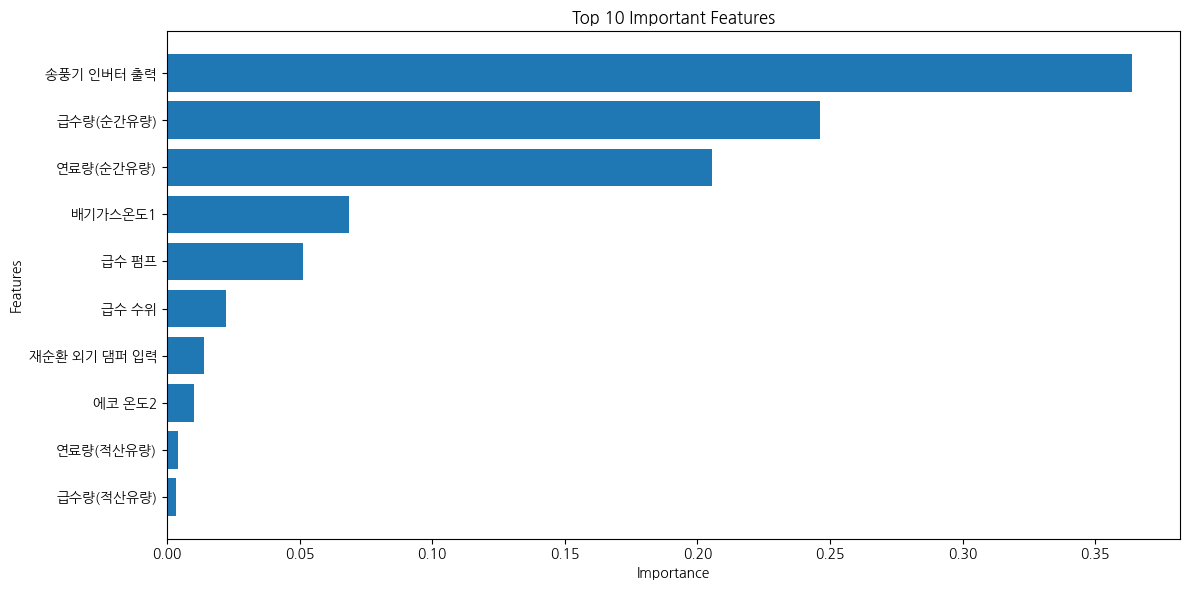

In [11]:
# Select the top 10 important features (or adjust the number as needed)
top_n = 10
top_features = importance.head(top_n).iloc[::-1] # Reverse the order

# Create a horizontal bar plot
plt.figure(figsize=(12, 6))
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top {} Important Features'.format(top_n))
plt.tight_layout()
plt.show()